BIKE

https://www.kaggle.com/competitions/bike-sharing-demand/
```
datetime - hourly date + timestamp  
season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
holiday - whether the day is considered a holiday
workingday - whether the day is neither a weekend nor holiday
weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
temp - temperature in Celsius
atemp - "feels like" temperature in Celsius
humidity - relative humidity
windspeed - wind speed
casual - number of non-registered user rentals initiated
registered - number of registered user rentals initiated
count - number of total rentals
```

In [2]:
import warnings
warnings.filterwarnings(action='ignore')
import re
from datetime import datetime, date, time, timedelta
from dateutil.relativedelta import relativedelta

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.rcParams['font.family']= 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams['figure.figsize'] = [6.4, 4.8]

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

<pre>
workingday  holiday
1           0          7412  [1]일하는날
0           0          3163  [0]주말
            1           311  [2]공휴일

In [25]:
train = pd.read_csv('./train.csv', parse_dates=['datetime'])
test = pd.read_csv('./test.csv', parse_dates=['datetime'])

df_list = [train, test]
for df in df_list:
    df.rename(columns={'datetime':'regdate'}, inplace=True)
    df['y'] = df['regdate'].dt.year
    df['m'] = df['regdate'].dt.month
    df['d'] = df['regdate'].dt.day
    df['h'] = df['regdate'].dt.hour
    df['w'] = df['regdate'].dt.dayofweek
    df.set_index('regdate', inplace=True)
    
    df['date_type'] = 0
    df['date_type'] = np.where( (df['holiday']==0) & (df['workingday'] == 1), 1, df['date_type'] )
    df['date_type'] = np.where( (df['holiday']==1) & (df['workingday'] == 0), 2, df['date_type'] )
    
    df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
 11  y           10886 non-null  int64  
 12  m           10886 non-null  int64  
 13  d           10886 non-null  int64  
 14  h           10886 non-null  int64  
 15  w           10886 non-null  int64  
 16  date_type   10886 non-null  int64  
dtypes: float64(3), int64(14)
memory usage: 1.5 MB
<class 'pandas.core.frame.

In [26]:
train[train['weather']==4]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,y,m,d,h,w,date_type
regdate,,,,,,,,,,,,,,,,,
2012-01-09 18:00:00,1,0,1,4,8.2,11.365,86,6.0032,6,158,164,2012,1,9,18,0,1


In [27]:
test[test['weather']==4]

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,y,m,d,h,w,date_type
regdate,,,,,,,,,,,,,,
2011-01-26 16:00:00,1,0,1,4,9.02,9.85,93,22.0028,2011,1,26,16,2,1
2012-01-21 01:00:00,1,0,0,4,5.74,6.82,86,12.9980,2012,1,21,1,5,0


## 이상치 제거

In [68]:
del_idx_list = []
idx = train[train['windspeed']>=50].index
del_idx_list.extend(idx)
del_idx_list

[Timestamp('2011-02-15 01:00:00'),
 Timestamp('2011-02-19 15:00:00'),
 Timestamp('2011-07-03 17:00:00'),
 Timestamp('2011-07-03 18:00:00')]

In [69]:
idx = train[train['weather']==4].index
del_idx_list.extend(idx)
del_idx_list

[Timestamp('2011-02-15 01:00:00'),
 Timestamp('2011-02-19 15:00:00'),
 Timestamp('2011-07-03 17:00:00'),
 Timestamp('2011-07-03 18:00:00'),
 Timestamp('2012-01-09 18:00:00')]

In [70]:
idx = train[train['temp']>=40].index
del_idx_list.extend(idx)
del_idx_list

[Timestamp('2011-02-15 01:00:00'),
 Timestamp('2011-02-19 15:00:00'),
 Timestamp('2011-07-03 17:00:00'),
 Timestamp('2011-07-03 18:00:00'),
 Timestamp('2012-01-09 18:00:00'),
 Timestamp('2012-07-07 16:00:00')]

In [71]:
print(train.shape)
train = train.drop(del_idx_list, axis=0)
print(train.shape)

(10886, 17)
(10880, 17)


In [54]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [145]:
ws0 = train[train['windspeed']==0]
ws1 = train[train['windspeed']!=0]
ws0.shape, ws1.shape

((1313, 17), (9567, 17))

In [48]:
train_test_w0 = pd.concat([train[train['windspeed']==0], test[test['windspeed']==0]], axis=0)
train_test_w0.drop(['windspeed', 'casual', 'registered', 'count'], axis=1)

,season,holiday,workingday,weather,temp,atemp,humidity,y,m,d,h,w,date_type
regdate,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,2011,1,1,0,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,2011,1,1,1,5,0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,2011,1,1,2,5,0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,2011,1,1,3,5,0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,2011,1,1,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-29 12:00:00,1,0,0,3,8.20,12.120,100,2012,12,29,12,5,0
2012-12-29 13:00:00,1,0,0,3,8.20,12.120,100,2012,12,29,13,5,0
2012-12-29 15:00:00,1,0,0,2,9.84,12.120,87,2012,12,29,15,5,0


In [63]:
ㅛㅛㅛㅛㅛ여기부터 개발 ㄱㄱㄱㄱ 

SyntaxError: invalid syntax (3618446773.py, line 1)

In [62]:
train_test_w1 = pd.concat([train[train['windspeed']!=0], test[test['windspeed']!=0]], axis=0)
train_test_w0 = pd.concat([train[train['windspeed']==0], test[test['windspeed']==0]], axis=0)

X_train = train_test_w1.drop(['windspeed', 'casual', 'registered', 'count'], axis=1)
y_train = train_test_w1['windspeed']
X_test = train_test_w0.drop(['windspeed', 'casual', 'registered', 'count'], axis=1)

model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
train_test_w0['windspeed'] = y_pred
train_test_w0

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,y,m,d,h,w,date_type
regdate,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,7.992296,3.0,13.0,16.0,2011,1,1,0,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,7.182601,8.0,32.0,40.0,2011,1,1,1,5,0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,6.822677,5.0,27.0,32.0,2011,1,1,2,5,0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,6.742679,3.0,10.0,13.0,2011,1,1,3,5,0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,6.572767,0.0,1.0,1.0,2011,1,1,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-29 12:00:00,1,0,0,3,8.20,12.120,100,12.081440,NaN,NaN,NaN,2012,12,29,12,5,0
2012-12-29 13:00:00,1,0,0,3,8.20,12.120,100,11.881244,NaN,NaN,NaN,2012,12,29,13,5,0
2012-12-29 15:00:00,1,0,0,2,9.84,12.120,87,8.471748,NaN,NaN,NaN,2012,12,29,15,5,0


랜덤포레스트 굿

In [ ]:
X_train = ws1.drop(['windspeed', 'casual', 'registered', 'regcount'], axis=1)
X_test  = ws0.drop(['windspeed', 'casual', 'registered', 'regcount'], axis=1)
y_train = ws1['windspeed']
print(X_train.shape, X_test.shape, y_train.shape)

model = RandomForestRegressor(random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_pred.shape

(9567, 13) (1313, 13) (9567,)


(1313,)

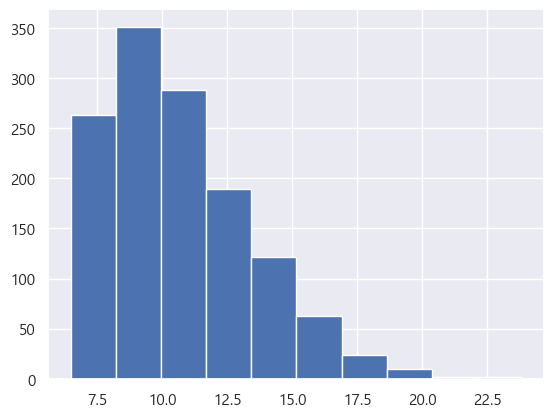

In [ ]:
plt.hist(y_pred)
plt.show()

In [172]:
ws0['windspeed'] = y_pred
train = pd.concat([ws0,ws1]).sort_index()
train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,regcount,y,m,d,h,w,day_type
regdate,,,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,8.431682,3,13,16,2011,1,1,0,5,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,8.041876,8,32,40,2011,1,1,1,5,0
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,7.951895,5,27,32,2011,1,1,2,5,0
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,7.132150,3,10,13,2011,1,1,3,5,0
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,6.942339,0,1,1,2011,1,1,4,5,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.695,50,26.002700,7,329,336,2012,12,19,19,2,1
2012-12-19 20:00:00,4,0,1,1,14.76,17.425,57,15.001300,10,231,241,2012,12,19,20,2,1
2012-12-19 21:00:00,4,0,1,1,13.94,15.910,61,15.001300,4,164,168,2012,12,19,21,2,1


# 최종 컬럼 선정
<pre>
타겟(1): 'casual' + 'registered'
   or
타겟(2): 'regcount'

삭제 컬럼: 'd',     'holiday', 'workingday',      'atemp',  'season'

시간 컬럼: 'y', 'm', 'h', 'w'

날짜 컬럼: 'day_type'

날씨 컬럼: 'season', 'weather', 'temp', 'humidity', 'windspeed'
       
       
다중공선: 분석피쳐중 상관계수가 높은 컬럼
'registered' <-> 'regcount' : regcount 삭제
'temp' <-> 'atemp' : atemp 삭제

'w' <-> 'day_type' : 나중에 고려대상
'season' <-> 'm' : season 삭제

결론
['casual', 'registered']
['m', 'h', 'y', 'w', 'weather', 'temp', 'humidity', 'windspeed', 'day_type']

# 학습 ㄱㄱ

https://www.latex4technics.com/?note=CMEL1Z

*  $ MSE = \frac{\mathrm{1} }{\mathrm{n}} \sum\nolimits_{i=1}^{n} (Y_i - \hat{Y_i})^{2}$

*  $ MAE = \frac{\mathrm{1} }{\mathrm{n}} \sum\nolimits_{i=1}^{n} |Y_i - \hat{Y_i}|$

*  $ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{Y_i - \hat{Y_i}}{N}\Big)^2}}$

*  $ RMSLE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{log(Y_i+1) - log(\hat{Y_i}+1)}{N}\Big)^2}}$

In [75]:
# !pip install xgboost
# !pip install lightgmb

In [132]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error

# 추가
from sklearn.ensemble import AdaBoostRegressor, VotingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [173]:
X = train[['m', 'h', 'y', 'w', 'weather', 'temp', 'humidity', 'windspeed', 'day_type']]
Y = train[['regcount', 'registered', 'casual']]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state=0, test_size=0.2)
dtr = DecisionTreeRegressor(random_state=0)
dtr.fit(X_train, Y_train)
dtr_pred = dtr.predict(X_test)

dtr_mse_regcount = mean_squared_error(Y_test['regcount'], dtr_pred.T[0])
dtr_mse_registered = mean_squared_error(Y_test['registered'], dtr_pred.T[1])
dtr_mse_casual = mean_squared_error(Y_test['casual'], dtr_pred.T[2])

print(dtr_mse_regcount, dtr_mse_registered, dtr_mse_casual)

3449.539981617647 2313.0822610294117 527.9283088235294


In [178]:
X = train[['m', 'h', 'y', 'w', 'weather', 'temp', 'humidity', 'windspeed', 'day_type']]
y_list = [train['regcount'], train['registered'], train['casual']]

for i, y in enumerate(y_list):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
    dtr = DecisionTreeRegressor(random_state=0)
    dtr.fit(X_train, y_train)
    y_pred = dtr.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    
    print(y_list[i].name)
    print('MSE', mse)
    print('RMSE', np.sqrt(mse))
    print()

regcount
MSE 4200.370404411765
RMSE 64.81026465315324

registered
MSE 2269.1107536764707
RMSE 47.63518398911114

casual
MSE 508.55480238970586
RMSE 22.55115966840078



In [175]:
X = train[['m', 'h', 'y', 'w', 'weather', 'temp', 'humidity', 'windspeed', 'day_type']]
y_list = [train['regcount'], train['registered'], train['casual']]
model_list = [
    ("DTR"   , DecisionTreeRegressor(random_state=0)),
    ("LR"    , LinearRegression()                   ),
    ("ABOOST", AdaBoostRegressor()                  ),
    ("XGB"   , XGBRegressor()                       ),  
    ("LGBM"  , LGBMRegressor()                      ),
    ("VR"    , VotingRegressor([("XGB", XGBRegressor()), ("LGBM", LGBMRegressor())]) ) 
]

res_list = []
for model_tuple in model_list:
    # print('model :', model_tuple[0])
    for i, y in enumerate(y_list):
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
        model = model_tuple[1]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        mse = mean_squared_error(y_test, y_pred)
        res_list.append([model_tuple[0], y_list[i].name, mse, np.sqrt(mse)])
    #     print(y_list[i].name)
    #     print('MSE   : ', mse)
    #     print('RMSE  : ', np.sqrt(mse))
    #     print()
    # print('-----------------------------')
res_df = pd.DataFrame(res_list, columns=['model', 'target', 'MSE', 'RMSE'])
res_df

,model,target,MSE,RMSE
0,DTR,regcount,4200.370404,64.810265
1,DTR,registered,2269.110754,47.635184
2,DTR,casual,508.554802,22.551160
3,LR,regcount,19679.716165,140.284412
4,LR,registered,15175.593189,123.189258
5,LR,casual,1332.521862,36.503724
6,ABOOST,regcount,11534.056557,107.396725
7,ABOOST,registered,7956.494063,89.199182
8,ABOOST,casual,1145.916687,33.851391
9,XGB,regcount,1787.135018,42.274520


In [176]:
res_df.pivot_table(index=['model', 'target'], values=['MSE', 'RMSE'])

MSE        RMSE
model  target                              
ABOOST casual       1145.916687   33.851391
       regcount    11534.056557  107.396725
       registered   7956.494063   89.199182
DTR    casual        508.554802   22.551160
       regcount     4200.370404   64.810265
       registered   2269.110754   47.635184
LGBM   casual        202.980599   14.247126
       regcount     1668.499960   40.847276
       registered   1129.824082   33.612856
LR     casual       1332.521862   36.503724
       regcount    19679.716165  140.284412
       registered  15175.593189  123.189258
VR     casual        194.671136   13.952460
       regcount     1585.672686   39.820506
       registered   1068.115578   32.682038
XGB    casual        211.438260   14.540917
       regcount     1787.135018   42.274520
       registered   1173.793569   34.260671

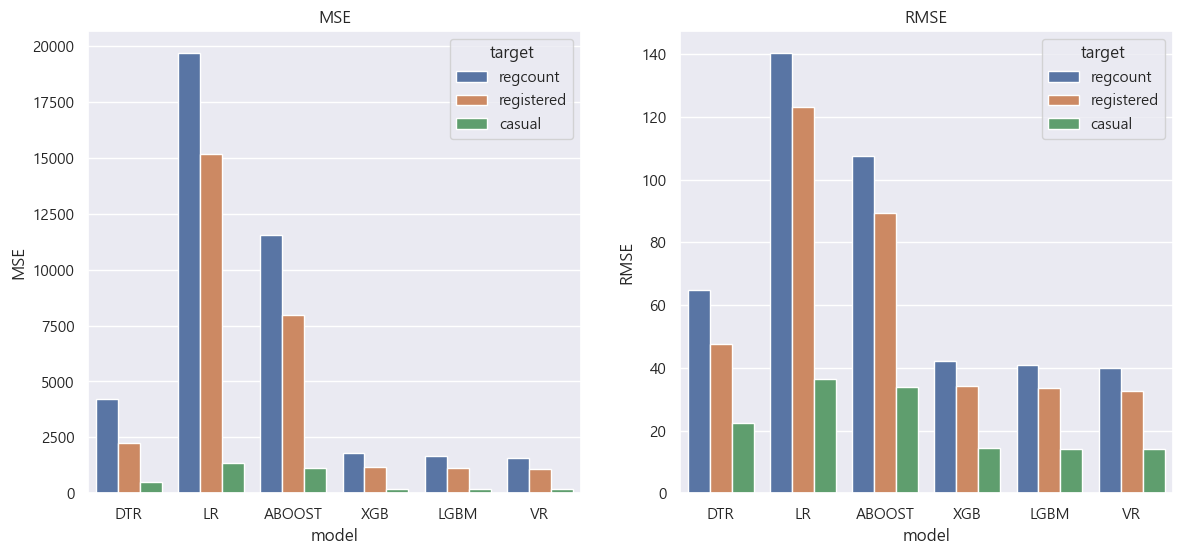

In [177]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.barplot(res_df, x='model', y='MSE', hue='target')
plt.title('MSE')

plt.subplot(1,2,2)
sns.barplot(res_df, x='model', y='RMSE', hue='target')
plt.title('RMSE')

plt.show()

In [206]:
sc_list = [
    ('Standard', StandardScaler()),
    ('MinMax', MinMaxScaler()),
    ('Robust', RobustScaler())
]
X = train[['m', 'h', 'y', 'w', 'weather', 'temp', 'humidity', 'windspeed', 'day_type']]
y_list = [train['regcount'], train['registered'], train['casual']]
model_list = [
    ("DTR"   , DecisionTreeRegressor(random_state=0)),
    ("LR"    , LinearRegression()                   ),
    ("ABOOST", AdaBoostRegressor()                  ),
    ("XGB"   , XGBRegressor()                       ),  
    ("LGBM"  , LGBMRegressor()                      ),
    ("VR"    , VotingRegressor([("XGB", XGBRegressor()), ("LGBM", LGBMRegressor())]) ) 
]

res_list = []
for j, sc in enumerate(sc_list):
    sc[1].fit(X)
    X = sc[1].transform(X)
    for model_tuple in model_list:
        # print('model :', model_tuple[0])
        for i, y in enumerate(y_list):
            X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)
            model = model_tuple[1]
            model.fit(X_train, y_train)
            y_pred = model.predict(X_test)

            mse = mean_squared_error(y_test, y_pred)
            res_list.append([sc[0], model_tuple[0], y_list[i].name, mse, np.sqrt(mse)])
        #     print(y_list[i].name)
        #     print('MSE   : ', mse)
        #     print('RMSE  : ', np.sqrt(mse))
        #     print()
        # print('-----------------------------')
res_df = pd.DataFrame(res_list, columns=['Scaler', 'model', 'target', 'MSE', 'RMSE'])
res_df

,Scaler,model,target,MSE,RMSE
0,Standard,DTR,regcount,4199.626379,64.804524
1,Standard,DTR,registered,2257.415901,47.512271
2,Standard,DTR,casual,507.320887,22.523785
3,Standard,LR,regcount,19679.716165,140.284412
4,Standard,LR,registered,15175.593189,123.189258
5,Standard,LR,casual,1332.521862,36.503724
6,Standard,ABOOST,regcount,10635.424328,103.128194
7,Standard,ABOOST,registered,9097.832759,95.382560
8,Standard,ABOOST,casual,1077.369217,32.823303
9,Standard,XGB,regcount,1784.885924,42.247910


In [208]:
res_df.sort_values('MSE')

,Scaler,model,target,MSE,RMSE
17,Standard,VR,casual,193.935483,13.926072
35,MinMax,VR,casual,194.643258,13.951461
53,Robust,VR,casual,195.191823,13.971107
14,Standard,LGBM,casual,201.754852,14.204043
32,MinMax,LGBM,casual,202.986596,14.247336
50,Robust,LGBM,casual,203.843100,14.277363
11,Standard,XGB,casual,211.059281,14.527879
47,Robust,XGB,casual,211.322781,14.536945
29,MinMax,XGB,casual,211.439759,14.540968
20,MinMax,DTR,casual,507.303424,22.523397


In [ ]:
plt.figure(figsize=(14,6))

plt.subplot(1,2,1)
sns.barplot(res_df, x='model', y='MSE', hue='target')
plt.title('MSE')

plt.subplot(1,2,2)
sns.barplot(res_df, x='model', y='RMSE', hue='target')
plt.title('RMSE')

plt.show()